# This file trains a CNN model to recognize the hardware we use in our robotics team
- Step 1 is to train a prebuilt model
- Step 2 is to build my own CNN model once I have access to more data

In [11]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.model_selection import train_test_split

In [52]:
path = '/Users/jasper/Desktop/CS/Organization_Project/data/dataset'
images = []
for folder in os.listdir(path):
    for image in os.listdir(os.path.join(path, folder)):
        img = Image.open(os.path.join(path, folder, image))
        img = img.convert('RGB')
        img = img.resize((224, 224))
        images.append((img, image.split("_")[0]))       

In [67]:
# Map labels to indices
label_set = sorted(set(label for _, label in images))
label_to_idx = {label: idx for idx, label in enumerate(label_set)}

In [69]:
# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
transformed_images = [(transform(img), label_to_idx[label]) for img, label in images]
train_data, test_data = train_test_split(transformed_images, test_size=0.2, random_state=42)
train_data[1][0].shape

torch.Size([3, 224, 224])

In [70]:
# Load the pre built model
model = models.mobilenet_v2(pretrained=True)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [71]:
num_classes = len(set([img[1] for img in images]))  # Unique class count

# Replace final classifier layer
model.classifier[1] = nn.Linear(model.last_channel, num_classes)

In [72]:
def eval_model(model, x, y):
    with torch.no_grad():
        y_pred = model(x)
        correctness = (y_pred.argmax(dim=1) == y)
        return correctness

In [79]:
def train(model: nn.Module, train_data: list, test_data: list, epochs: int = 10, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    losses = []
    
    for epoch in range(epochs):
        # Unpack images and labels
        x_list, y_list = zip(*train_data)
        
        # Convert to tensors
        y = torch.tensor(list(y_list)).to("cpu")
        x = torch.stack(x_list).to("cpu")
        
        # Forward pass
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        # Format test data
        x_test, y_test = zip(*test_data)
        x_test_tensor = torch.stack(x_test).to("cpu")
        y_test_tensor = torch.tensor(list(y_test)).to("cpu")
        
        # Evalute model on test set
        correct = torch.sum(eval_model(model, x_test_tensor, y_test_tensor))
        total = len(x_test_tensor)
        print(f"Epoch {epoch+1}: Accuracy on test set: {correct}/{total} ({(correct / total) * 100:.2f}%)")
    
    return losses

Epoch 1/10, Loss: 1.459956169128418
Epoch 1: Accuracy on test set: 10/11 (90.91%)
Epoch 2/10, Loss: 0.15547014772891998
Epoch 2: Accuracy on test set: 11/11 (100.00%)
Epoch 3/10, Loss: 0.018356673419475555
Epoch 3: Accuracy on test set: 10/11 (90.91%)
Epoch 4/10, Loss: 0.0048233745619654655
Epoch 4: Accuracy on test set: 10/11 (90.91%)
Epoch 5/10, Loss: 0.0017234219703823328
Epoch 5: Accuracy on test set: 10/11 (90.91%)
Epoch 6/10, Loss: 0.000674583250656724
Epoch 6: Accuracy on test set: 10/11 (90.91%)
Epoch 7/10, Loss: 0.00039383754483424127
Epoch 7: Accuracy on test set: 10/11 (90.91%)
Epoch 8/10, Loss: 0.00022860776516608894
Epoch 8: Accuracy on test set: 10/11 (90.91%)
Epoch 9/10, Loss: 0.0001571553002577275
Epoch 9: Accuracy on test set: 10/11 (90.91%)
Epoch 10/10, Loss: 0.00011217691644560546
Epoch 10: Accuracy on test set: 10/11 (90.91%)


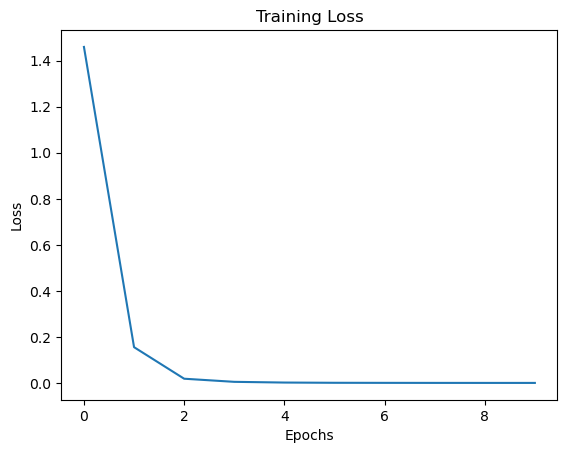

In [80]:
my_model = model.to("cpu")
loss = train(my_model, train_data, test_data, epochs=10, lr=0.001)
# Save the model
torch.save(my_model.state_dict(), 'model.pth')
# Graph the loss
import matplotlib.pyplot as plt
plt.plot(loss)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()